In [1]:
# Default style
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

#Import the dependences
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Python SQL toolkit and Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text, func, DateTime, Column

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text, func, DateTime, Column

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
#################### OPTION2: # Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine) # ORM
conn = engine.connect() # Raw SQL/Pandas in case want to test
#session.query(func.count(measurement.date)).all()

In [10]:
# check the data in the table station (just for viewing)
query = text("""Select * FROM station LIMIT 2""")
df = pd.read_sql(query, con=conn)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [11]:
# check the data in the table measurement(just for viewing)
query = text("""Select * FROM measurement WHERE date = '2010-01-01' LIMIT 2""")
df = pd.read_sql(query, con=conn)
df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2725,USC00513117,2010-01-01,0.28,67.0


# Exploratory Precipitation Analysis

In [13]:
############## Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Start with most recent Date in the data set: sort by date 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [14]:
# OPTION 2: Find the most recent date(ORM): 
most_recent_date_string = session.query(func.max(Measurement.date)).scalar()
most_recent_date

('2017-08-23',)

In [15]:
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

In [16]:
# Option 3: the same resuls as option 1 & 2
query = text("""SELECT max(date) FROM measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

In [17]:
# Convert the string to a datetime object using strptime, specifying the format of your date string:
most_recent_date = datetime.strptime(most_recent_date_string, '%Y-%m-%d')  # Adjust the format as needed

In [18]:
# Calculate the date one year from the last date in data set.
twelve_months_ago = most_recent_date - timedelta(days=365)
print("Twelve months ago:", twelve_months_ago)

Twelve months ago: 2016-08-23 00:00:00


In [19]:
# retrieve the data and precipitation scores with raw SQL
query = text("""SELECT 
                id,
                station,
                date,
                prcp,
                tobs
            FROM 
                measurement 
            WHERE 
                date >= '2016-08-23' 
            ORDER BY 
                date;""")
df1 = pd.read_sql(query, con=conn)
df1

,id,station,date,prcp,tobs
0,2364,USC00519397,2016-08-23,0.00,81.0
1,5091,USC00513117,2016-08-23,0.15,76.0
2,7331,USC00514830,2016-08-23,0.05,80.0
3,8825,USC00517948,2016-08-23,NaN,80.0
4,11851,USC00519523,2016-08-23,0.02,80.0
...,...,...,...,...,...
2225,19549,USC00516128,2017-08-22,0.50,76.0
2226,2724,USC00519397,2017-08-23,0.00,81.0
2227,7635,USC00514830,2017-08-23,0.00,82.0
2228,12187,USC00519523,2017-08-23,0.08,82.0


In [20]:
# df1=df.sort_values(by="date") 
# df1.head()

In [21]:
#  Option 2: Perform a query to retrieve the data and precipitation scores with ORM
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= twelve_months_ago).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_option2 = pd.DataFrame(rows) # if don't use order-by as above we can add this at the end:   sort_values(by='date') 
df_option2.head(10)

,id,station,date,prcp,tobs
0,2365,USC00519397,2016-08-24,0.08,79.0
1,5092,USC00513117,2016-08-24,2.15,76.0
2,7332,USC00514830,2016-08-24,2.28,80.0
3,8826,USC00517948,2016-08-24,NaN,78.0
4,11852,USC00519523,2016-08-24,1.22,79.0
5,14609,USC00519281,2016-08-24,2.15,77.0
6,19203,USC00516128,2016-08-24,1.45,74.0
7,2366,USC00519397,2016-08-25,0.08,80.0
8,5093,USC00513117,2016-08-25,0.08,77.0
9,7333,USC00514830,2016-08-25,0.00,81.0


In [22]:
# # Change 'date' to a datetime format
# df['date'] = pd.to_datetime(df['date'])
# df.info()

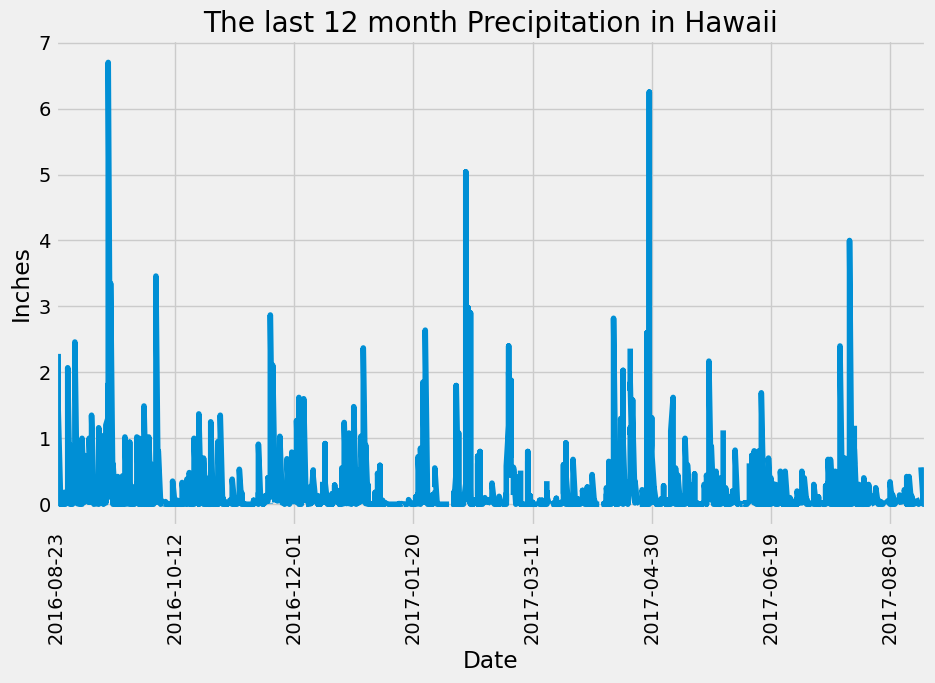

In [23]:
# Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df1.date,df1.prcp,label='precipitation')
#plt.plot(df1['date'],df1['prcp'], color='skyblue',label='precipitation')
plt.title("The last 12 month Precipitation in Hawaii")
plt.xlabel("Date")
plt.ylabel("Inches")

# Adjust the x-ticks 
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=9))

# Set x-ticks, y-ticks
plt.xticks(rotation=90)

# Set x and y limits
plt.xlim(df1['date'].min(), df1['date'].max())

# Show the plot
plt.show()

<Figure size 1000x700 with 0 Axes>

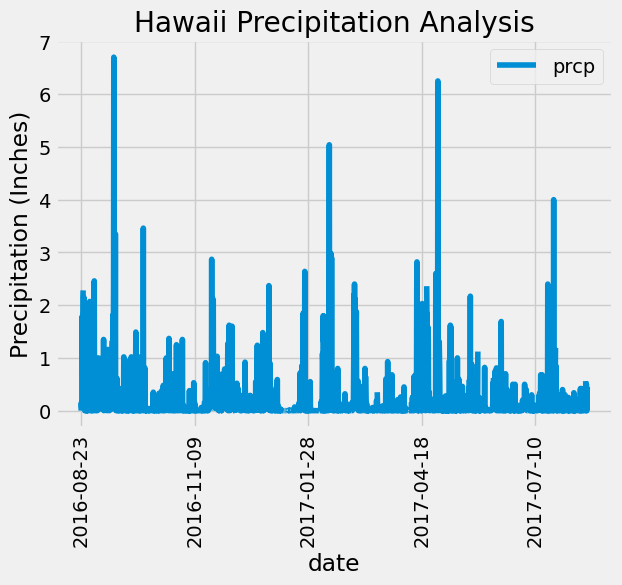

In [70]:
#OPTION 2: Use Pandas's plot
plt.figure(figsize=(10,7))
df1.plot(x="date",y="prcp", rot=90)
plt.title("Hawaii Precipitation Analysis")
plt.ylabel("Precipitation (Inches)")
plt.show()

In [25]:
#Use Pandas to print the summary statistics for the precipitation data.
print(df1['prcp'].describe())

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [27]:
Base.classes.keys()

['measurement', 'station']

In [28]:
# Design a query to calculate the total number of stations in the dataset
#total_station = session.query(Station).count()
total_station= session.query(func.count(func.distinct(Measurement.station))).all()
total_station

[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

count_row_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

for station, count in count_row_stations:
        print(f"Station: {station}, count: {count}")

Station: USC00519281, count: 2772
Station: USC00519397, count: 2724
Station: USC00513117, count: 2709
Station: USC00519523, count: 2669
Station: USC00516128, count: 2612
Station: USC00514830, count: 2202
Station: USC00511918, count: 1979
Station: USC00517948, count: 1372
Station: USC00518838, count: 511


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations = count_row_stations[0][0] # Get the station ID of the most active station
most_active_stations
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_stations).all()
# Print the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]
print(f"Station: {most_active_stations}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month_temp = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_stations).\
filter(Measurement.date >=twelve_months_ago).\
all()
# Extract the temperature values from the query result
temperatures = [temp[0] for temp in last_12month_temp]
temperatures

[77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,
 69.0,

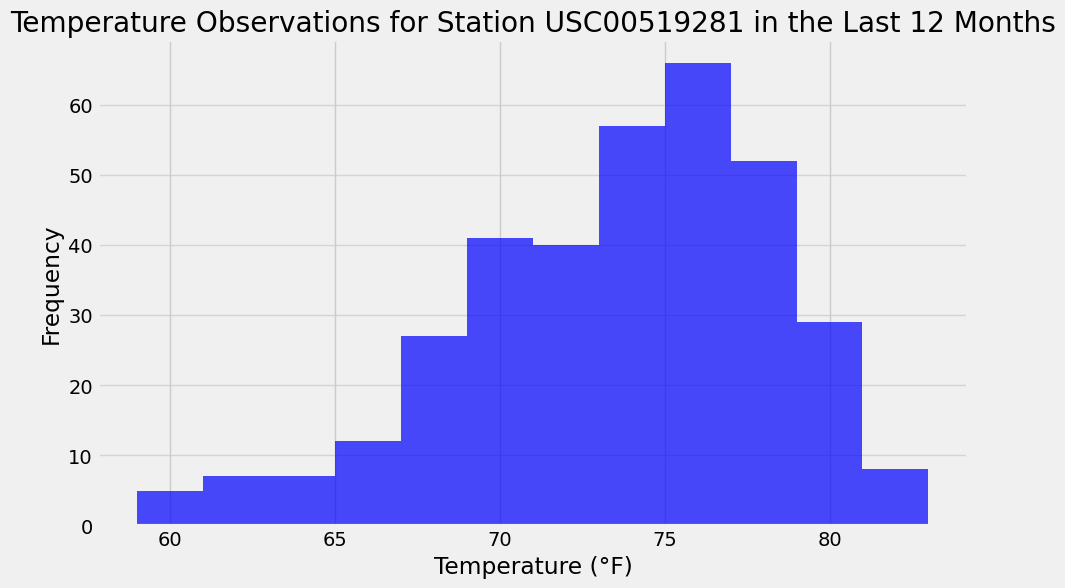

In [32]:
# Step 3: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_stations} in the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [34]:
# Close Session
session.close()
